In [25]:
import pandas as pd

file_path = 'mapped_data.csv'  # 你的檔案名稱
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='gb18030')

print(df.shape)

(71952, 22)


In [26]:
df['osm_tag'].unique()

array(['restaurant', 'cafe', 'fast_food', 'ice_cream', 'office',
       'greenhouse', 'industrial', 'barn', 'parking', 'bus_station',
       'parking_entrance', 'public', 'loading_dock', 'bar', 'nightclub',
       'sports_centre', 'gambling', 'internet_cafe', 'commercial',
       'theatre', 'cinema', 'hospital', 'hotel', 'dojo', 'clinic',
       'pharmacy', 'dentist', 'veterinary', 'apartments', 'detached',
       'dormitory', 'residential', 'service', 'warehouse', 'post_office',
       'retail', 'charging_station', 'grave_yard', 'training',
       'arts_centre', 'driving_school', 'kindergarten',
       'exhibition_centre', 'school', 'college', 'library', 'university',
       'marketplace', 'bank', 'atm', 'car_wash', 'fuel'], dtype=object)

### 宜興市數據統計資料

In [27]:
h3_l7_df_YX = pd.read_csv('h3_l7_df_yixing.csv')
h3_l7_df_YX

,id,apartments,arts_centre,atm,bank,bar,barn,bus_station,cafe,car_wash,...,church,terrace,pavilion,stadium,cabin,boathouse,riding_hall,construction,ship,ruins
0,87309e000ffffff,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,87309e001ffffff,0,0,0,0,0,0,9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,87309e002ffffff,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,87309e003ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,87309e004ffffff,0,0,1,3,0,0,7,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,87309ebb2ffffff,9,0,1,1,1,0,10,4,0,...,0,0,0,0,0,0,0,0,0,0
428,87309ebb3ffffff,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
429,87309ebb4ffffff,0,0,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
430,87309ebb5ffffff,0,0,1,4,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0


成功對應到 432 個網格。


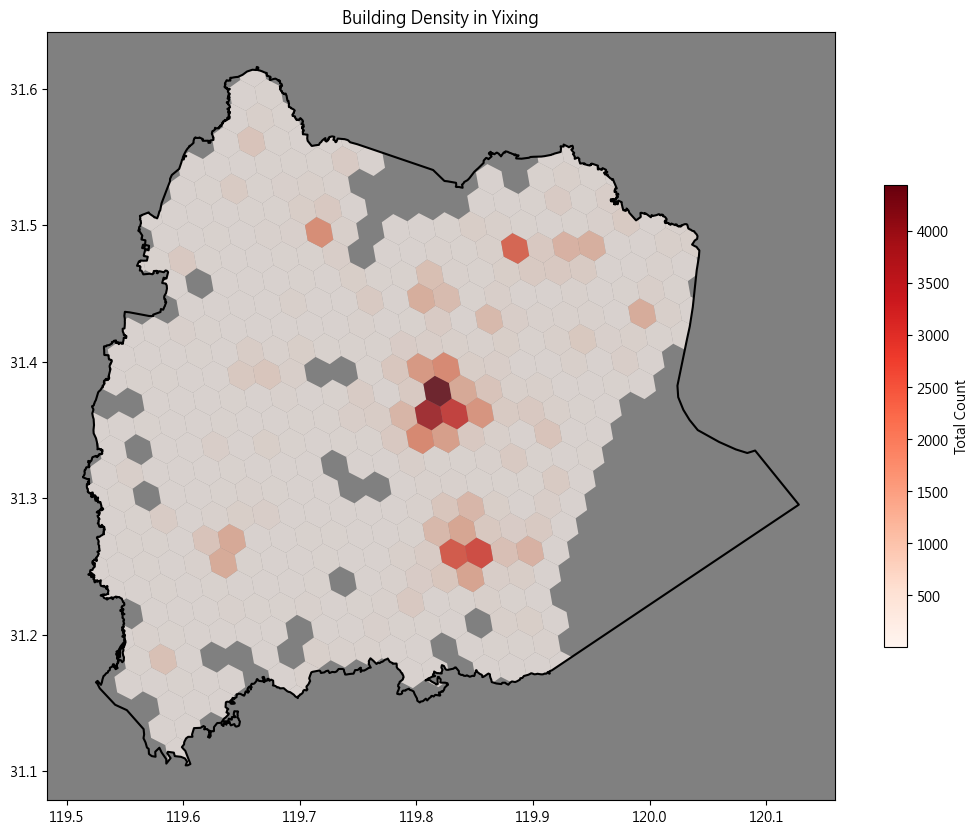

In [28]:
import matplotlib.pyplot as plt
import osmnx as ox
import h3
import geopandas as gpd
from shapely.geometry import Polygon

# 1. 獲取行政區 (宜興)
districts = ox.geocode_to_gdf(['Yixing, Wuxi, Jiangsu, China'])

# 2. 處理 H3 Data (假設 h3_l7_df 已經存在)
#    確保你的 h3_l7_df 裡面的 H3 ID 真的是屬於宜興的
#    這裡我們先計算 total_value
cols_to_sum = [c for c in h3_l7_df_YX.columns if c != 'id']
h3_l7_df_YX['total_value'] = h3_l7_df_YX[cols_to_sum].sum(axis=1)

# 3. 將 H3 DataFrame 轉換為 GeoDataFrame (這一步是關鍵優化)
def h3_to_polygon(h3_id):
    # geo_json=True 返回 (lon, lat)，符合 GeoPandas/Matplotlib 的 (x, y) 順序
    boundary = h3.h3_to_geo_boundary(h3_id, geo_json=True)
    return Polygon(boundary)

# 建立幾何欄位
h3_l7_df_YX['geometry'] = h3_l7_df_YX['id'].apply(h3_to_polygon)
# 轉為 GeoDataFrame
gdf_h3 = gpd.GeoDataFrame(h3_l7_df_YX, geometry='geometry', crs="EPSG:4326")

# 4. 重要的 Debug：過濾掉不在地圖範圍內的網格
# 這樣可以確保只畫出位於宜興內部的網格
gdf_h3_clipped = gpd.clip(gdf_h3, districts)

# 如果 clipped 後是空的，代表你的 H3 數據根本不在這個區域
if gdf_h3_clipped.empty:
    print("警告：沒有任何 H3 網格位於選定的行政區內！請檢查數據來源經緯度。")
else:
    print(f"成功對應到 {len(gdf_h3_clipped)} 個網格。")

# 5. 繪圖
fig, ax = plt.subplots(figsize=(12.7, 12))

# 畫底圖 (行政區)
districts.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, zorder=2)

# 畫網格 (一次性繪製，比 for 迴圈快非常多)
if not gdf_h3_clipped.empty:
    gdf_h3_clipped.plot(
        column='total_value',
        ax=ax,
        cmap='Reds',
        alpha=0.7,
        legend=True,
        legend_kwds={'label': "Total Count", 'shrink': 0.5},
        zorder=1
    )

ax.set_facecolor('grey')
ax.set_title('Building Density in Yixing') 
plt.show()

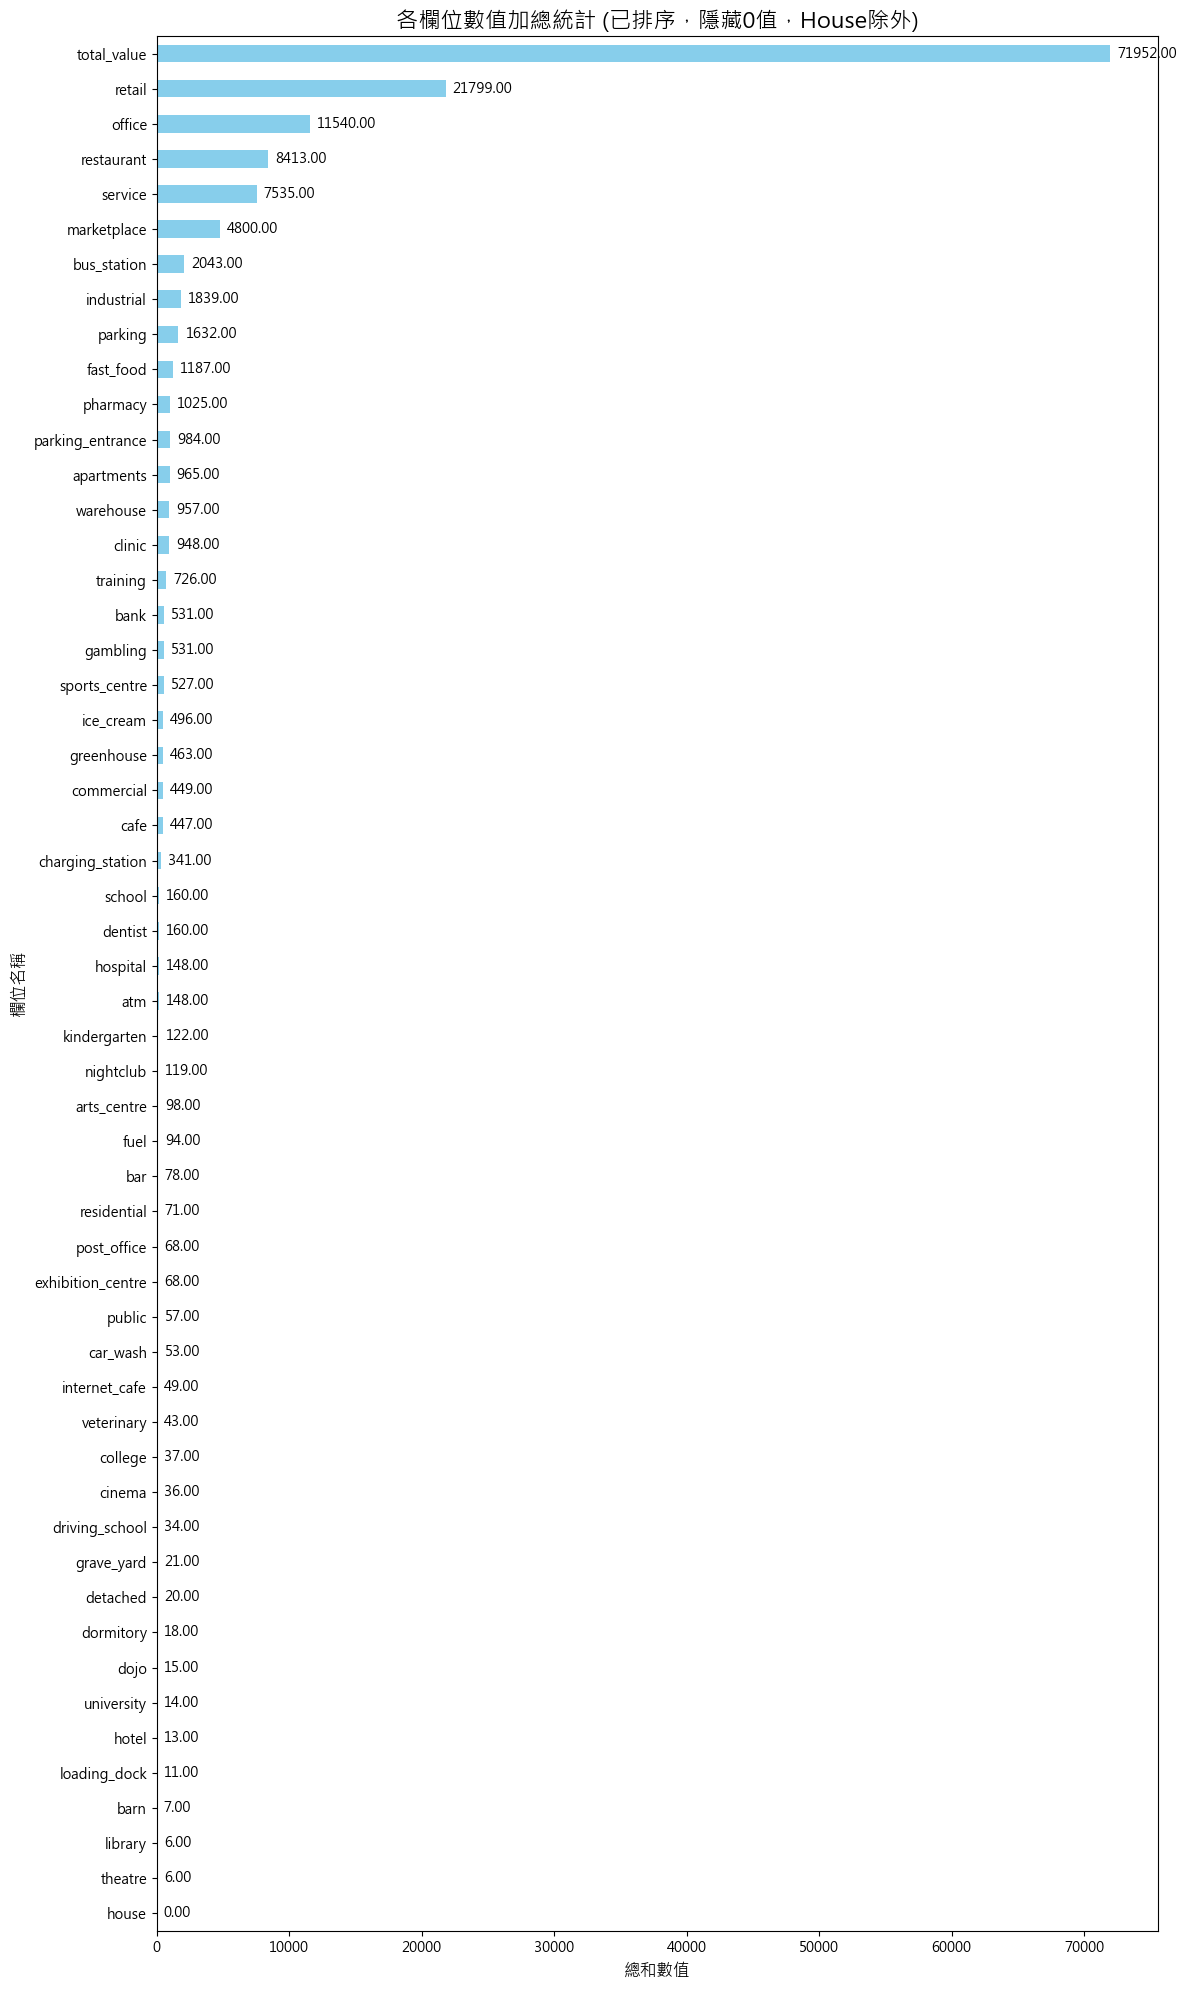

In [29]:
# --- 假設 numeric_sum 已經存在 ---
# numeric_sum_filtered = numeric_sum[(numeric_sum != 0) | (numeric_sum.index == 'house')]

# select_dtypes(include=['number']) 會自動篩選出 int 和 float 類型的欄位進行加總
numeric_sum = h3_l7_df_YX.select_dtypes(include=['number']).sum()
numeric_sum_filtered = numeric_sum[
    (numeric_sum != 0) | (numeric_sum.index == 'house')
]

# ==========================================
# ★★★ 修改重點：資料排序 ★★★
# ==========================================
# 我們希望圖表「由上往下」看是「由大到小」
# 因為 barh 是從底部(y=0)開始畫，所以我們要將資料排成「從小到大」
# 這樣最大的數值會是最後一筆，從而畫在圖表的最頂端
numeric_sum_filtered = numeric_sum_filtered.sort_values(ascending=True)

# --- 2. 設定中文字型 ---
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# --- 3. 建立圖表 ---
# 橫向圖建議高度 (20) 拉長，以免欄位名稱重疊
plt.figure(figsize=(12, 20)) 

# 畫圖
ax = numeric_sum_filtered.plot(kind='barh', color='skyblue')

# --- 4. 加入標題與標籤 ---
plt.title('各欄位數值加總統計 (已排序，隱藏0值，House除外)', fontsize=16)
plt.xlabel('總和數值', fontsize=12)
plt.ylabel('欄位名稱', fontsize=12)

# --- 5. 標示數值 ---
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.2f}', 
                (width, p.get_y() + p.get_height() / 2.), 
                ha='left', 
                va='center', 
                fontsize=10,
                xytext=(5, 0), 
                textcoords='offset points')

# --- 6. 顯示圖表 ---
plt.tight_layout()
plt.show()